In [57]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [93]:
# Dataset

class SinDS(Dataset):

    # f(x) = x + 5sin(x)
    def __init__(self, n_samples=1000, n_features=1, mean=0, std=1, noise=0, device=torch.device('cpu')):
        self.x_data = torch.rand(n_samples, n_features, device=device) * std + mean
        self.y_data = self.x_data + 5.0*torch.sin(self.x_data)
        self.y_data += (torch.rand(n_samples, 1) - 0.5) * noise if noise else 0

        self.n_samples = n_samples

    def __getitem__(self, item):
        return self.x_data[item], self.y_data[item]

    def __len__(self):
        return self.n_samples

In [143]:
# Hyper-parameters 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 50
batch_size = 5
n_samples = 1000
test_n_samples = 100
n_features = 1
learning_rate = 0.01
mean = -10
std = 20
noise = 4

In [144]:
# Preparing datasets
train_dataset_easy = SinDS(n_samples=n_samples, mean=mean, std=std, device=device)
test_dataset_easy = SinDS(n_samples=test_n_samples, mean=mean, std=std, device=device)
train_dataset_noise = SinDS(n_samples=n_samples, mean=mean, std=std, noise=noise, device=device)
test_dataset_noise = SinDS(n_samples=test_n_samples, mean=mean, std=std, noise=noise, device=device)

# Preparing dataloaders
train_dataloader_easy = DataLoader(train_dataset_easy, batch_size=batch_size, shuffle=True)
test_dataloader_easy = DataLoader(test_dataset_easy, batch_size=batch_size, shuffle=False)
train_dataloader_noise = DataLoader(train_dataset_noise, batch_size=batch_size, shuffle=True)
test_dataloader_noise = DataLoader(test_dataset_noise, batch_size=batch_size, shuffle=False)

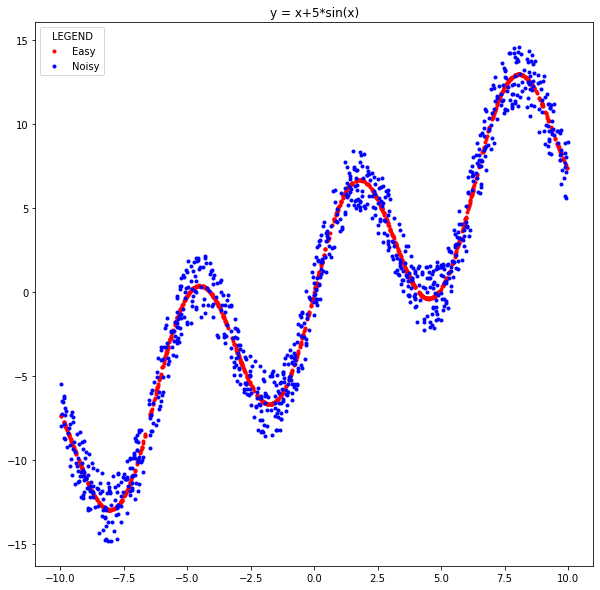

In [145]:
# Plot
plt.figure(figsize=(10, 10))
plt.plot(train_dataset_easy.x_data, train_dataset_easy.y_data, '.', c='r')
plt.plot(train_dataset_noise.x_data, train_dataset_noise.y_data, '.', c='b')
plt.title('y = x+5*sin(x)')
plt.legend(['Easy', 'Noisy'], title='LEGEND')
plt.show()

In [146]:
# Model

class Net(nn.Module):
    def __init__(self, input_features, hidden_size, output_features):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_features, hidden_size)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(hidden_size, output_features)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

In [147]:
# Models, criterion, optimizers

model_easy = Net(n_features, 10, 1).to(device) # Easy case model
model_noise = Net(n_features, 10, 1).to(device) # Noisy case model
criterion = nn.MSELoss()
optimizer_easy = torch.optim.Adam(model_easy.parameters(), lr=learning_rate)
optimizer_noise = torch.optim.Adam(model_noise.parameters(), lr=learning_rate)

#### Training easy case

In [148]:
n_total_steps = len(train_dataloader_easy)

for epoch in range(n_epochs):
    for i, (inputs, values) in enumerate(train_dataloader_easy):
        
        # moving to device
        inputs = inputs.reshape(-1, n_features).to(device)
        values.to(device)
        
        # Forward pass
        outputs = model_easy(inputs)
        loss = criterion(outputs, values)
        
        # Backward and optimize
        optimizer_easy.zero_grad()
        loss.backward()
        optimizer_easy.step()
        
        if ((i+1) % 50 == 0) and ((epoch+1) % 5 == 0):
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [5/50], Step [50/200], Loss: 22.9821
Epoch [5/50], Step [100/200], Loss: 12.0681
Epoch [5/50], Step [150/200], Loss: 7.7240
Epoch [5/50], Step [200/200], Loss: 18.0359
Epoch [10/50], Step [50/200], Loss: 12.3094
Epoch [10/50], Step [100/200], Loss: 16.1026
Epoch [10/50], Step [150/200], Loss: 14.9283
Epoch [10/50], Step [200/200], Loss: 5.7804
Epoch [15/50], Step [50/200], Loss: 9.2231
Epoch [15/50], Step [100/200], Loss: 7.7821
Epoch [15/50], Step [150/200], Loss: 2.8920
Epoch [15/50], Step [200/200], Loss: 6.3589
Epoch [20/50], Step [50/200], Loss: 9.1782
Epoch [20/50], Step [100/200], Loss: 5.6006
Epoch [20/50], Step [150/200], Loss: 6.5224
Epoch [20/50], Step [200/200], Loss: 4.8456
Epoch [25/50], Step [50/200], Loss: 0.7265
Epoch [25/50], Step [100/200], Loss: 4.1772
Epoch [25/50], Step [150/200], Loss: 3.0763
Epoch [25/50], Step [200/200], Loss: 1.4884
Epoch [30/50], Step [50/200], Loss: 2.5581
Epoch [30/50], Step [100/200], Loss: 8.1673
Epoch [30/50], Step [150/200], Loss:

In [149]:
# Evaluating

with torch.no_grad():
    preds = model_easy(test_dataset_easy.x_data)

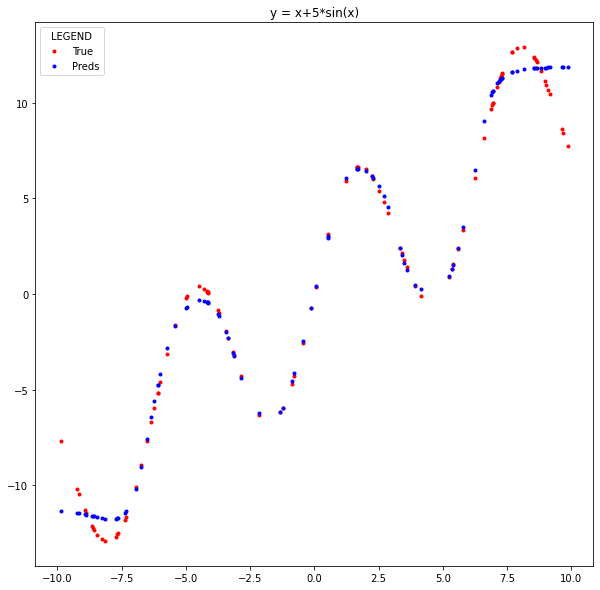

In [150]:
# Plot
plt.figure(figsize=(10, 10))
plt.plot(test_dataset_easy.x_data, test_dataset_easy.y_data, '.', c='r')
plt.plot(test_dataset_easy.x_data, preds, '.', c='b')
plt.title('y = x+5*sin(x)')
plt.legend(['True', 'Preds'], title='LEGEND')
plt.show()

#### Training noisy case

In [153]:
n_total_steps = len(train_dataloader_noise)

for epoch in range(n_epochs):
    for i, (inputs, values) in enumerate(train_dataloader_noise):
        
        # moving to device
        inputs = inputs.reshape(-1, n_features).to(device)
        values.to(device)
        
        # Forward pass
        outputs = model_noise(inputs)
        loss = criterion(outputs, values)
        
        # Backward and optimize
        optimizer_noise.zero_grad()
        loss.backward()
        optimizer_noise.step()
        
        if ((i+1) % 50 == 0) and ((epoch+1) % 5 == 0):
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [5/50], Step [50/200], Loss: 26.4757
Epoch [5/50], Step [100/200], Loss: 3.3824
Epoch [5/50], Step [150/200], Loss: 15.8715
Epoch [5/50], Step [200/200], Loss: 21.4452
Epoch [10/50], Step [50/200], Loss: 14.2584
Epoch [10/50], Step [100/200], Loss: 8.6538
Epoch [10/50], Step [150/200], Loss: 12.4505
Epoch [10/50], Step [200/200], Loss: 2.0654
Epoch [15/50], Step [50/200], Loss: 7.4291
Epoch [15/50], Step [100/200], Loss: 8.6899
Epoch [15/50], Step [150/200], Loss: 14.6914
Epoch [15/50], Step [200/200], Loss: 6.5467
Epoch [20/50], Step [50/200], Loss: 11.4035
Epoch [20/50], Step [100/200], Loss: 8.5390
Epoch [20/50], Step [150/200], Loss: 3.4959
Epoch [20/50], Step [200/200], Loss: 8.8505
Epoch [25/50], Step [50/200], Loss: 5.3193
Epoch [25/50], Step [100/200], Loss: 2.3899
Epoch [25/50], Step [150/200], Loss: 6.1690
Epoch [25/50], Step [200/200], Loss: 7.5064
Epoch [30/50], Step [50/200], Loss: 3.0893
Epoch [30/50], Step [100/200], Loss: 5.3519
Epoch [30/50], Step [150/200], Loss

In [155]:
# Evaluating

with torch.no_grad():
    preds = model_noise(test_dataset_noise.x_data)

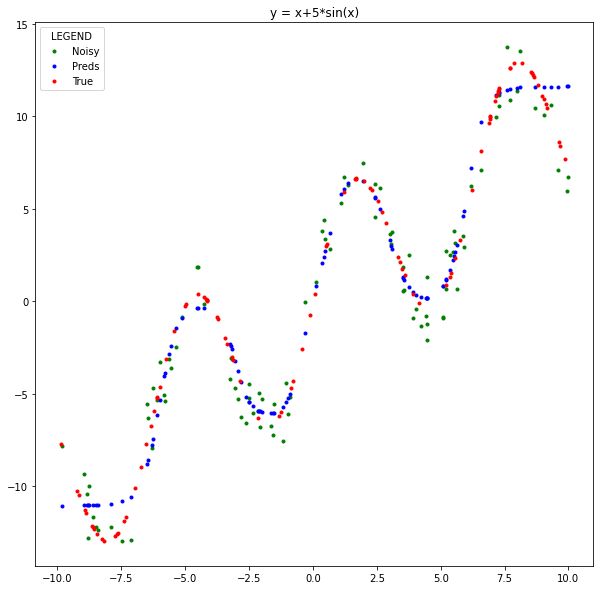

In [157]:
# Plot
plt.figure(figsize=(10, 10))
plt.plot(test_dataset_noise.x_data, test_dataset_noise.y_data, '.', c='g')
plt.plot(test_dataset_noise.x_data, preds, '.', c='b')
plt.plot(test_dataset_easy.x_data, test_dataset_easy.y_data, '.', c='r')
plt.title('y = x+5*sin(x)')
plt.legend(['Noisy', 'Preds', 'True'], title='LEGEND')
plt.show()

### Model analysis

In [232]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/root')

# Model
class AnalysisNet(nn.Module):
    def __init__(self, input_features, hidden_size, output_features):
        super(AnalysisNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_features, hidden_size)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(hidden_size, output_features)
        
        # Tracking history of sigmoid() outputs
        self.sout1 = []
        self.sout2 = []
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        self.sout1.append(x)
        x = self.fc2(x)
        x = self.act2(x)
        self.sout2.append(x)
        x = self.fc3(x)
        return x
    
model = AnalysisNet(n_features, 10, 1)
# writer.add_graph(model, train_dataset_easy.x_data)
# writer.close()

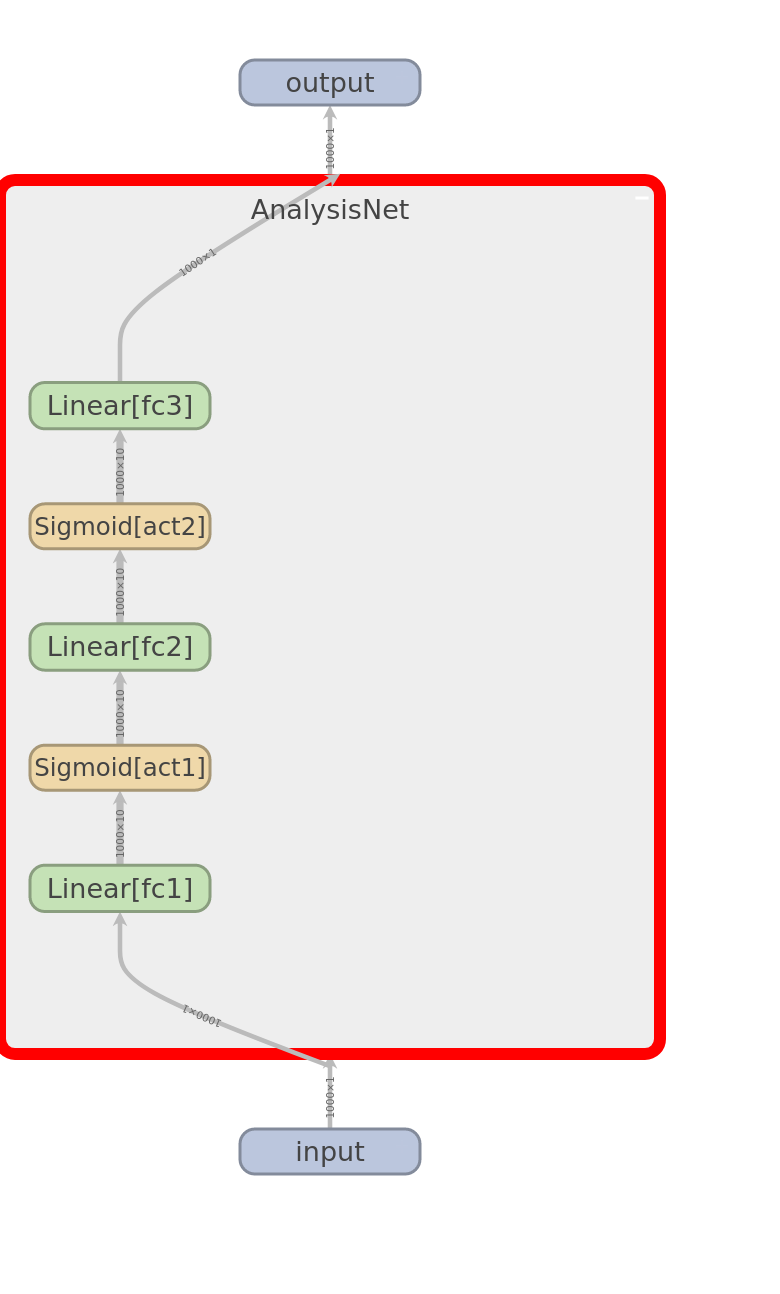

In [284]:
from IPython.display import Image
Image(filename='./data/root.png')

#### Sigmoid outputs analysis

In [224]:
with torch.no_grad():
    output = model(train_dataset_noise.x_data)

In [225]:
sigmoid1_outs = torch.cat(model.sout1).numpy()
sigmoid2_outs = torch.cat(model.sout2).numpy()

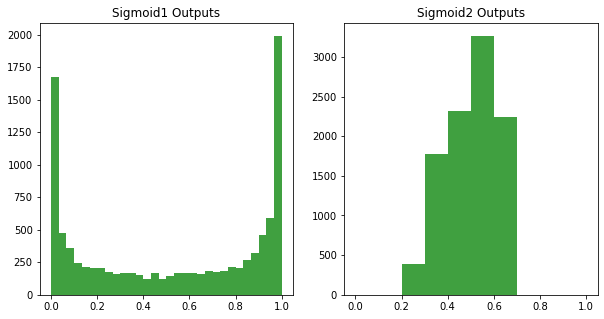

In [228]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(sigmoid1_outs.ravel(), 30, range=(0, 1), facecolor='g', alpha=0.75)
plt.title('Sigmoid1 Outputs')
plt.subplot(122)
plt.hist(sigmoid2_outs.ravel(), 10, range=(0, 1), facecolor='g', alpha=0.75)
plt.title('Sigmoid2 Outputs')
plt.show()

##### Conclusion

Most of sigmoid1 outputs are either 0 or 1 => zero gradients in backward()

### Trying out tanh activations

In [241]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/tanh')

# Model
class TanhModel(nn.Module):
    def __init__(self, input_features, hidden_size, output_features):
        super(TanhModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_features, hidden_size)
        self.act1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(hidden_size, output_features)
        
        # Tracking history of sigmoid() outputs
        self.tout1 = []
        self.tout2 = []
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        self.tout1.append(x)
        x = self.fc2(x)
        x = self.act2(x)
        self.tout2.append(x)
        x = self.fc3(x)
        return x
    
model = TanhModel(n_features, 10, 1).to(device)
# writer.add_graph(model, train_dataset_easy.x_data)
# writer.close()

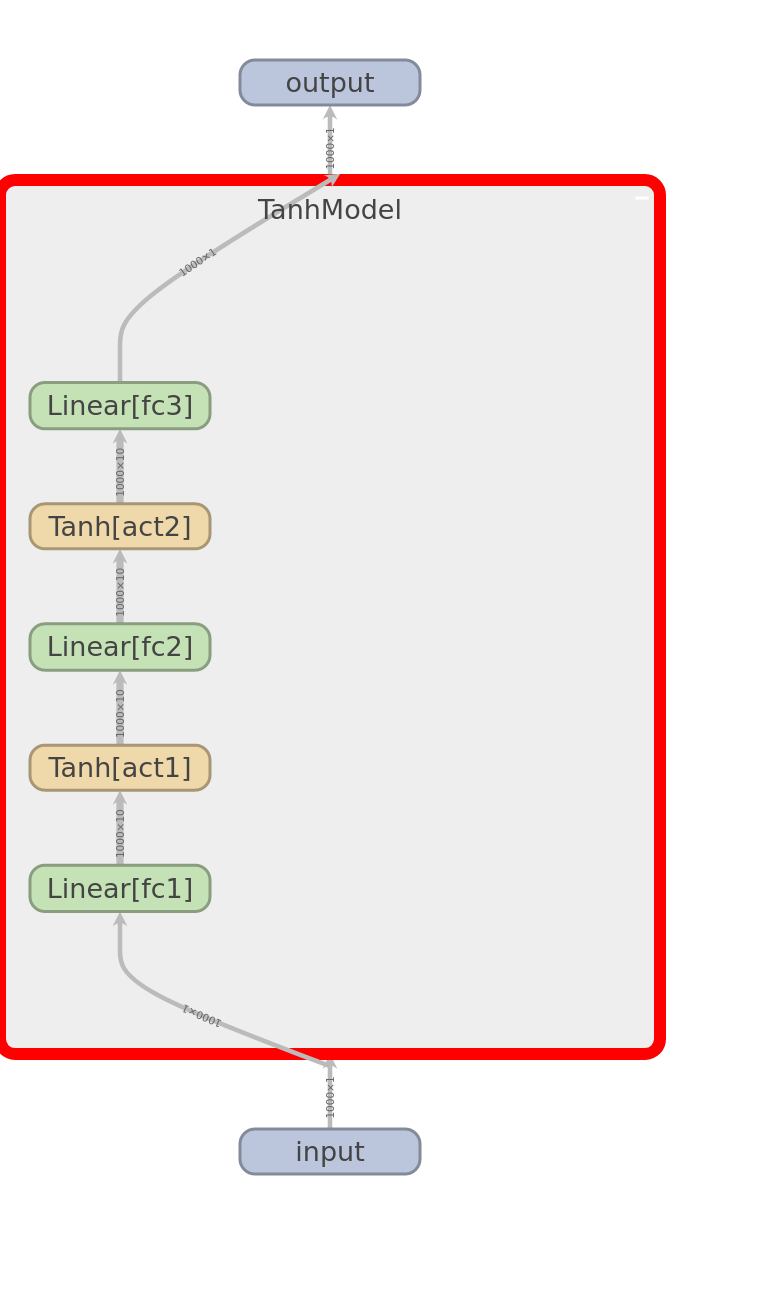

In [285]:
from IPython.display import Image
Image(filename='./data/tanh.png')

#### Tanh output analysis

In [237]:
with torch.no_grad():
    output = model(train_dataset_noise.x_data)

In [238]:
tanh1_outs = torch.cat(model.tout1).numpy()
tanh2_outs = torch.cat(model.tout2).numpy()

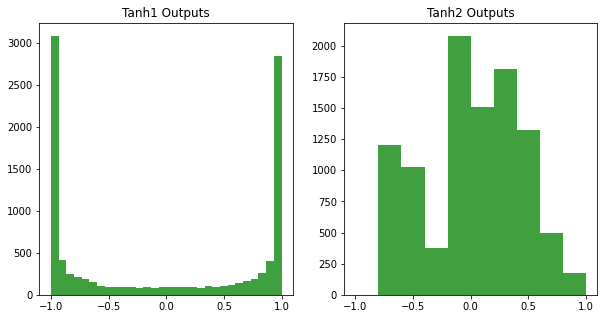

In [240]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(tanh1_outs.ravel(), 30, range=(-1, 1), facecolor='g', alpha=0.75)
plt.title('Tanh1 Outputs')
plt.subplot(122)
plt.hist(tanh2_outs.ravel(), 10, range=(-1, 1), facecolor='g', alpha=0.75)
plt.title('Tanh2 Outputs')
plt.show()

##### Conclusion

tanh is not the best option to use too

### Trying out ReLU activations

In [256]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/relu')

# Model
class ReLUModel(nn.Module):
    def __init__(self, input_features, hidden_size, output_features):
        super(ReLUModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_features, hidden_size)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.act2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(hidden_size, output_features)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x
    
model = ReLUModel(n_features, 10, 1).to(device)
# writer.add_graph(model, train_dataset_easy.x_data)
# writer.close()

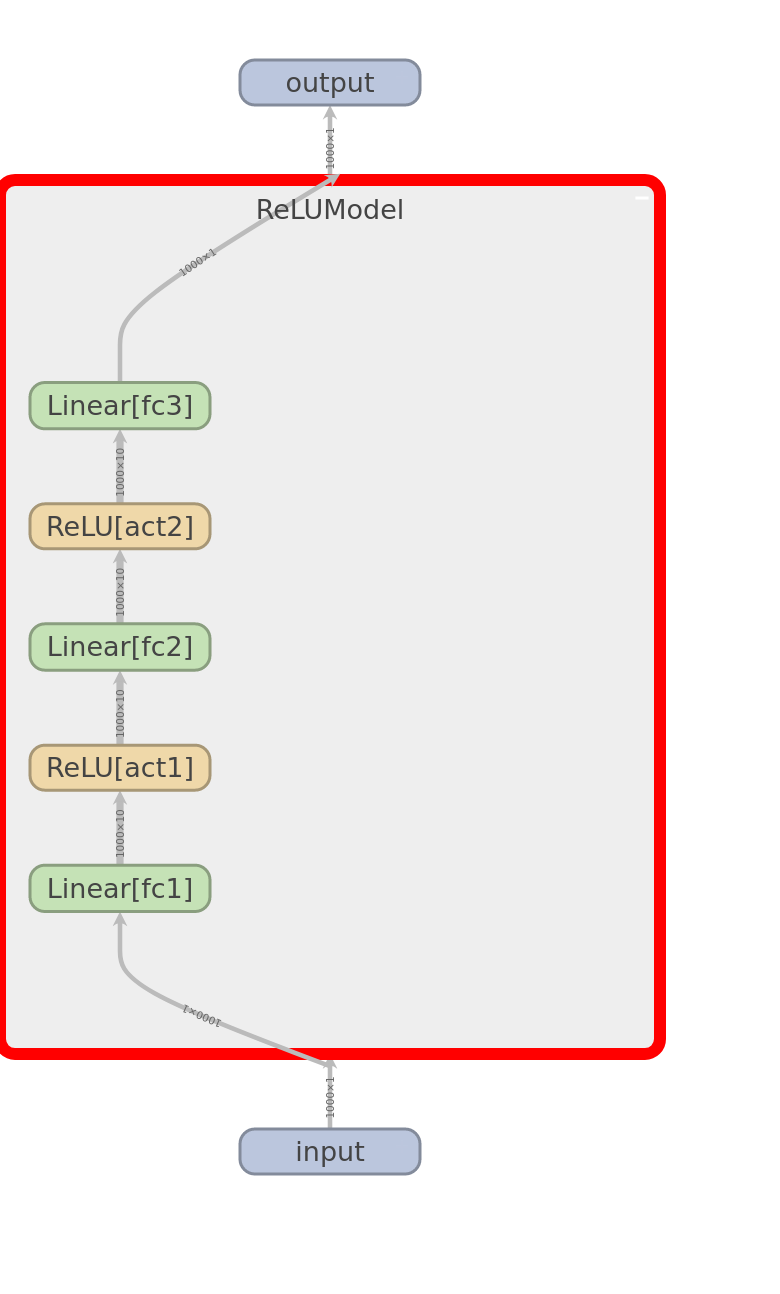

In [286]:
from IPython.display import Image
Image(filename='./data/relu.png')

In [257]:
# Models, criterion, optimizers
n_epochs = 50
learning_rate = 0.005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [258]:
n_total_steps = len(train_dataloader_noise)

for epoch in range(n_epochs):
    for i, (inputs, values) in enumerate(train_dataloader_noise):
        
        # moving to device
        inputs = inputs.reshape(-1, n_features).to(device)
        values.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, values)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if ((i+1) % 50 == 0) and ((epoch+1) % 5 == 0):
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [5/50], Step [50/200], Loss: 21.5582
Epoch [5/50], Step [100/200], Loss: 7.6950
Epoch [5/50], Step [150/200], Loss: 6.9580
Epoch [5/50], Step [200/200], Loss: 10.2852
Epoch [10/50], Step [50/200], Loss: 12.4043
Epoch [10/50], Step [100/200], Loss: 10.7472
Epoch [10/50], Step [150/200], Loss: 9.1968
Epoch [10/50], Step [200/200], Loss: 6.9663
Epoch [15/50], Step [50/200], Loss: 13.3396
Epoch [15/50], Step [100/200], Loss: 6.5471
Epoch [15/50], Step [150/200], Loss: 2.0559
Epoch [15/50], Step [200/200], Loss: 6.2014
Epoch [20/50], Step [50/200], Loss: 14.3979
Epoch [20/50], Step [100/200], Loss: 14.2267
Epoch [20/50], Step [150/200], Loss: 12.3311
Epoch [20/50], Step [200/200], Loss: 13.8488
Epoch [25/50], Step [50/200], Loss: 7.9919
Epoch [25/50], Step [100/200], Loss: 18.8590
Epoch [25/50], Step [150/200], Loss: 15.5254
Epoch [25/50], Step [200/200], Loss: 9.6136
Epoch [30/50], Step [50/200], Loss: 9.2564
Epoch [30/50], Step [100/200], Loss: 16.2730
Epoch [30/50], Step [150/200],

In [260]:
# Evaluating

with torch.no_grad():
    preds = model(test_dataset_noise.x_data)

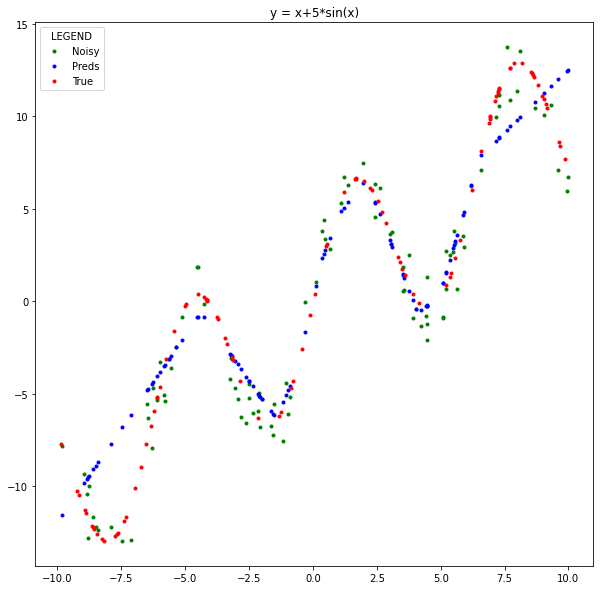

In [261]:
# Plot
plt.figure(figsize=(10, 10))
plt.plot(test_dataset_noise.x_data, test_dataset_noise.y_data, '.', c='g')
plt.plot(test_dataset_noise.x_data, preds, '.', c='b')
plt.plot(test_dataset_easy.x_data, test_dataset_easy.y_data, '.', c='r')
plt.title('y = x+5*sin(x)')
plt.legend(['Noisy', 'Preds', 'True'], title='LEGEND')
plt.show()a

### Trying out Leaky ReLU activations

In [281]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/lrelu')

# Model
class LReLUModel(nn.Module):
    def __init__(self, input_features, hidden_size, output_features):
        super(LReLUModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_features, hidden_size)
        self.act1 = torch.nn.LeakyReLU()
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.act2 = torch.nn.LeakyReLU()
        self.fc3 = torch.nn.Linear(hidden_size, output_features)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x
    
model = LReLUModel(n_features, 10, 1).to(device)
# writer.add_graph(model, train_dataset_easy.x_data)
# writer.close()

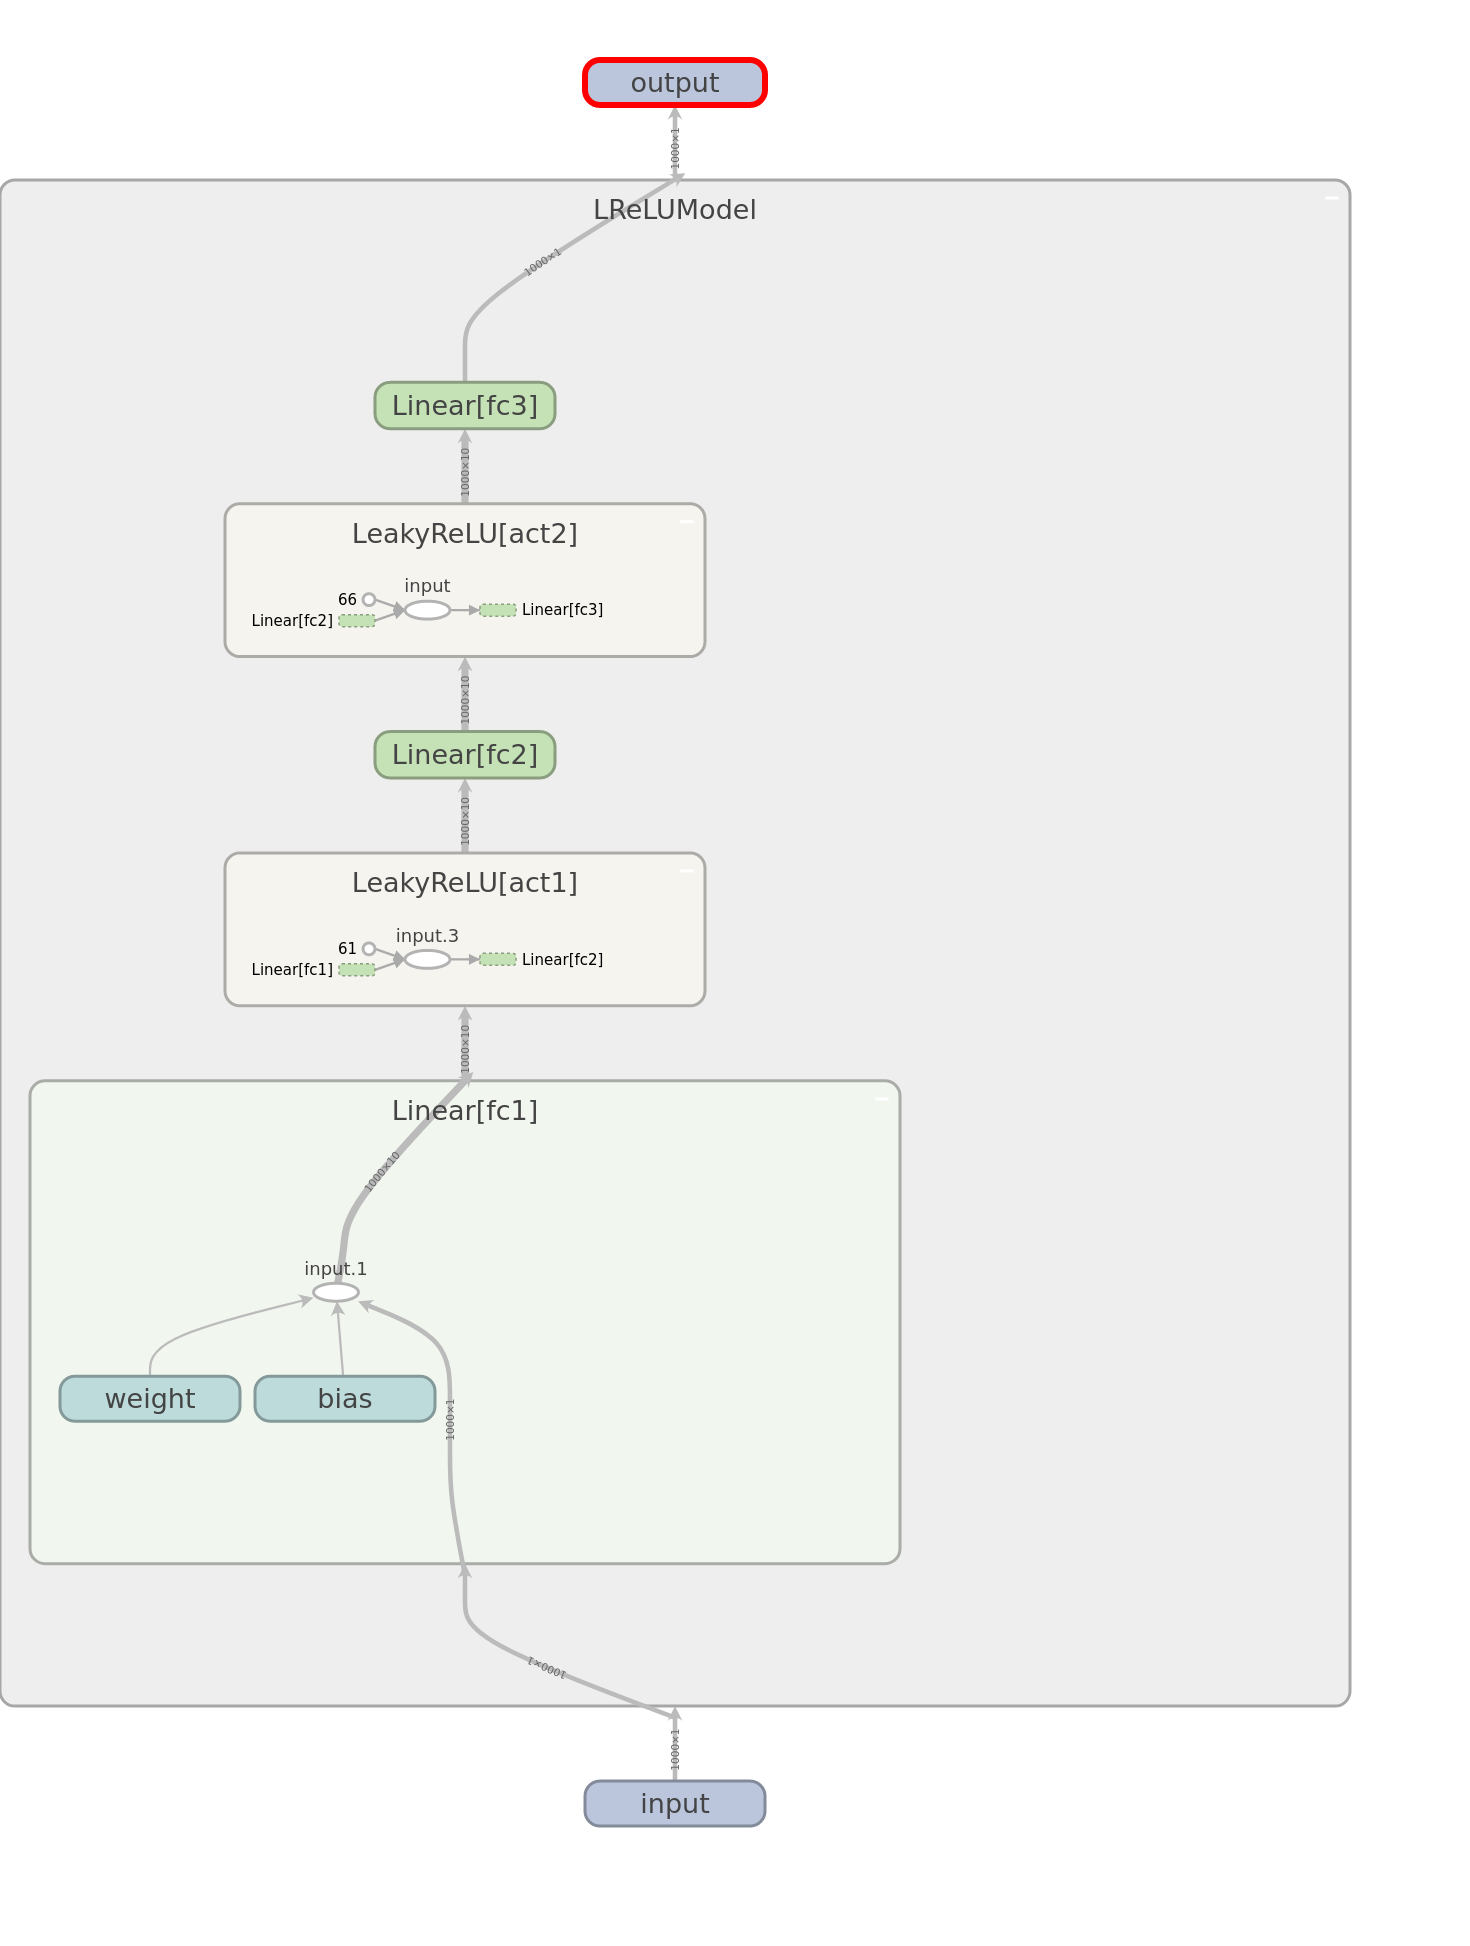

In [287]:
from IPython.display import Image
Image(filename='./data/lrelu.png')

In [282]:
# Models, criterion, optimizers
n_epochs = 50
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [283]:
writer = SummaryWriter(f'runs/lr{learning_rate}')

n_total_steps = len(train_dataloader_noise)
running_loss = 0

for epoch in range(n_epochs):
    for i, (inputs, values) in enumerate(train_dataloader_noise):
        
        # moving to device
        inputs = inputs.reshape(-1, n_features).to(device)
        values.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, values)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if ((i+1) % 50 == 0):
            writer.add_scalar('training_loss', running_loss / 50., global_step=epoch * n_total_steps + i)
            running_loss = 0
            if (epoch+1) % 5 == 0:
                print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
writer.close()

Epoch [5/50], Step [50/200], Loss: 6.8810
Epoch [5/50], Step [100/200], Loss: 10.0794
Epoch [5/50], Step [150/200], Loss: 12.2380
Epoch [5/50], Step [200/200], Loss: 12.9086
Epoch [10/50], Step [50/200], Loss: 14.0143
Epoch [10/50], Step [100/200], Loss: 11.3393
Epoch [10/50], Step [150/200], Loss: 13.1403
Epoch [10/50], Step [200/200], Loss: 16.6404
Epoch [15/50], Step [50/200], Loss: 7.8136
Epoch [15/50], Step [100/200], Loss: 16.8313
Epoch [15/50], Step [150/200], Loss: 8.5363
Epoch [15/50], Step [200/200], Loss: 9.2211
Epoch [20/50], Step [50/200], Loss: 11.8383
Epoch [20/50], Step [100/200], Loss: 17.5456
Epoch [20/50], Step [150/200], Loss: 12.5869
Epoch [20/50], Step [200/200], Loss: 14.1773
Epoch [25/50], Step [50/200], Loss: 25.2502
Epoch [25/50], Step [100/200], Loss: 11.3071
Epoch [25/50], Step [150/200], Loss: 6.1656
Epoch [25/50], Step [200/200], Loss: 25.6500
Epoch [30/50], Step [50/200], Loss: 16.1049
Epoch [30/50], Step [100/200], Loss: 8.3105
Epoch [30/50], Step [150/2

In [266]:
# Evaluating

with torch.no_grad():
    preds = model(test_dataset_noise.x_data)

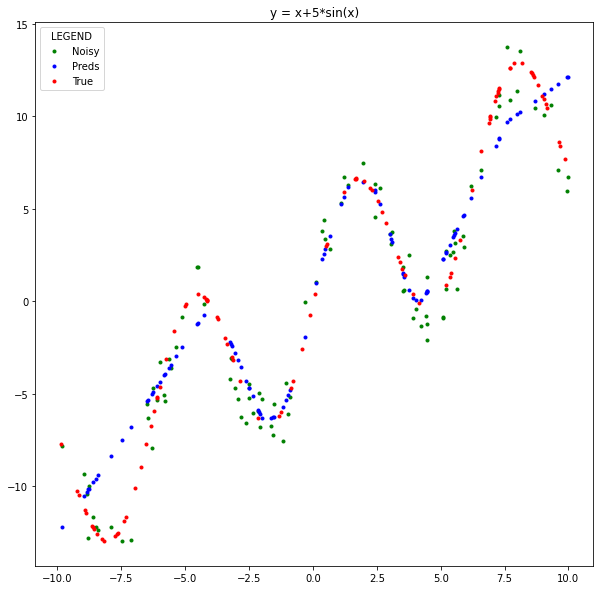

In [267]:
# Plot
plt.figure(figsize=(10, 10))
plt.plot(test_dataset_noise.x_data, test_dataset_noise.y_data, '.', c='g')
plt.plot(test_dataset_noise.x_data, preds, '.', c='b')
plt.plot(test_dataset_easy.x_data, test_dataset_easy.y_data, '.', c='r')
plt.title('y = x+5*sin(x)')
plt.legend(['Noisy', 'Preds', 'True'], title='LEGEND')
plt.show()

#### Learning rate analysis


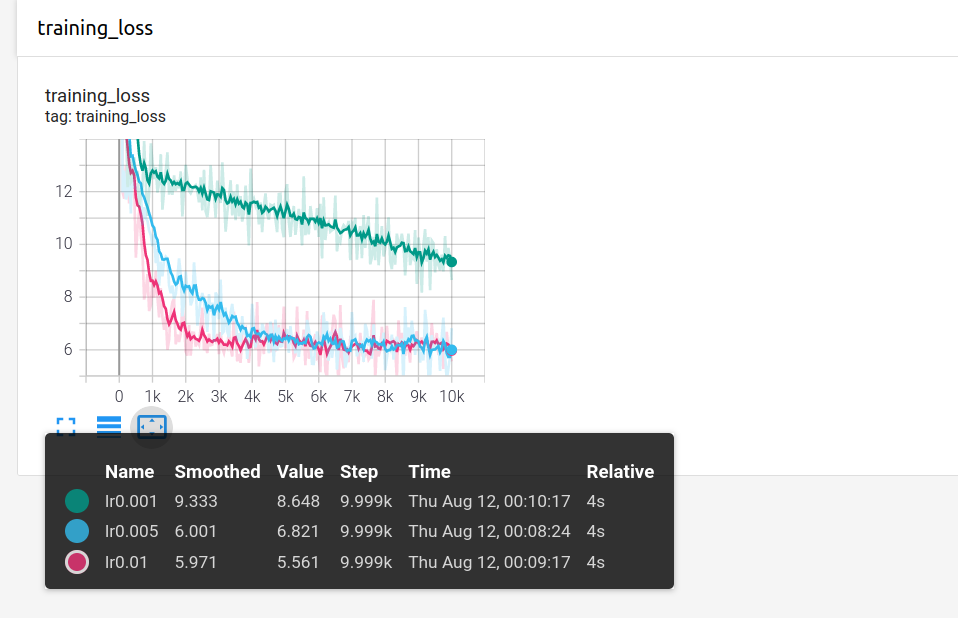

In [288]:
from IPython.display import Image
Image(filename='./data/lrs.png')

### Conclusions

Though sigmoid activation is definitely not the best idea, in this case it fits as the model has only two hidden layers and consequently two activations. Tanh doesn't make any considerable changes. ReLU learning is a bit slow and leaky relu looks better as it doesn't saturate. Low learning rate here demands much more training epochs while 0.01 learning rate model fits its best loss in only 3.000 training steps.